In [24]:
# Imports and Environment Setup

from pathlib import Path
import sys
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Environment setup
import dotenv
dotenv.load_dotenv(".env", override=True) # Defines MONGO_URI

# Local
project_root = Path.cwd().parent
src_path = str(project_root / "src")
if src_path not in sys.path:
    sys.path.append(src_path)

from analysis.fetch import fetch_images, fetch_chainguard_images, global_latest_scan
from analysis.remediation import fetch_remediations, fetch_chainguard_remediations
from analysis.alpine import list_cgr_alpine
from analysis.stat import RemediationTable
from analysis.plot.hist import rtime_hist
from analysis.plot.timeline import rtime_timeline

In [2]:
# Collect Remediations

CSV_FILE = "remediations.csv"

if not os.path.exists(CSV_FILE):
    tab = fetch_remediations()
    tab._df.to_csv(CSV_FILE, index=False, escapechar="\\")

df = pd.read_csv(CSV_FILE)
df["first_seen_at"] = pd.to_datetime(df["first_seen_at"])
df["remediated_at"] = pd.to_datetime(df["remediated_at"])
tab = RemediationTable(df)

# Filter out Chainguard images based on alpine
OMIT_CSV = "omit.csv"

omit_df = pd.read_csv(OMIT_CSV)
for _, row in omit_df.iterrows():
    tab = tab.filter(repository=row["repository"],
                     purge=True)

print(f"Found {tab._df.shape[0]} scans ending on on {tab.latest_remediation()}")

Found 82535 scans ending on on 2024-06-03 02:01:47.081000


In [3]:
cgr_tab = tab.filter(registry="cgr.dev")
cgr_tab = cgr_tab.resolve_edge_cases(remediated_at=False)
n_discovered = cgr_tab.discovered().shape[0]

remediated_df = cgr_tab.remediated()
n_remediated = remediated_df.shape[0]
rtime = remediated_df["rtime"].mean()

severe_rtime = remediated_df[remediated_df["registry"] != "chainguard/mariadb"]["rtime"].mean()

print(f"N Discovered: {n_discovered}")
print(f"N Remediated: {n_remediated}")
print(f"Mean Remediation Time: {rtime / 24:.2f} days")
print(f"Mean Severe Remediation Time: {severe_rtime / 24:.2f} days")

Resolving edge-cases: 100%|██████████| 1088/1088 [00:00<00:00, 7526.06it/s]

N Discovered: 1088
N Remediated: 1062
Mean Remediation Time: 2.18 days
Mean Severe Remediation Time: 2.18 days


In [11]:
"""
Display stats by label

Considers all CVEs seen on day 1 introduced on day 1.
"""

labels = ["docker-official", "ubi", "cgr-public"]
resolved_tab = tab.resolve_edge_cases(remediated_at=False)
for label in labels:
    label_tab = resolved_tab.filter(label=label)
    n_discovered = label_tab.discovered().shape[0]
    rem_df = label_tab.remediated()
    n_remediated = rem_df.shape[0]
    rtime = rem_df["rtime"].mean()
    severe_rtime = rem_df[rem_df["severity"].isin(["critical", "high"])]["rtime"].mean()
    print(label + ":")
    print(f"\tDiscovered: {n_discovered}")
    print(f"\tRemediated: {n_remediated}")
    print(f"\tRemediation time: {rtime / 24:.2f} days") 
    print(f"\tRemediation time (critical + high only): {severe_rtime / 24:.2f} days")

Resolving edge-cases: 100%|██████████| 82535/82535 [00:07<00:00, 11168.68it/s]


docker-official:
	Discovered: 18745
	Remediated: 11741
	Remediation time: 10.88 days
	Remediation time (critical + high only): 11.42 days
ubi:
	Discovered: 62345
	Remediated: 34006
	Remediation time: 15.19 days
	Remediation time (critical + high only): 13.31 days
cgr-public:
	Discovered: 1088
	Remediated: 1062
	Remediation time: 2.18 days
	Remediation time (critical + high only): 8.83 days


(array([949.,  47.,  31.,   6.,   7.,  12.,   7.,   0.,   2.,   1.]),
 array([3.73275000e-02, 4.01682277e+00, 7.99631804e+00, 1.19758133e+01,
        1.59553086e+01, 1.99348038e+01, 2.39142991e+01, 2.78937944e+01,
        3.18732897e+01, 3.58527849e+01, 3.98322802e+01]),
 <BarContainer object of 10 artists>)

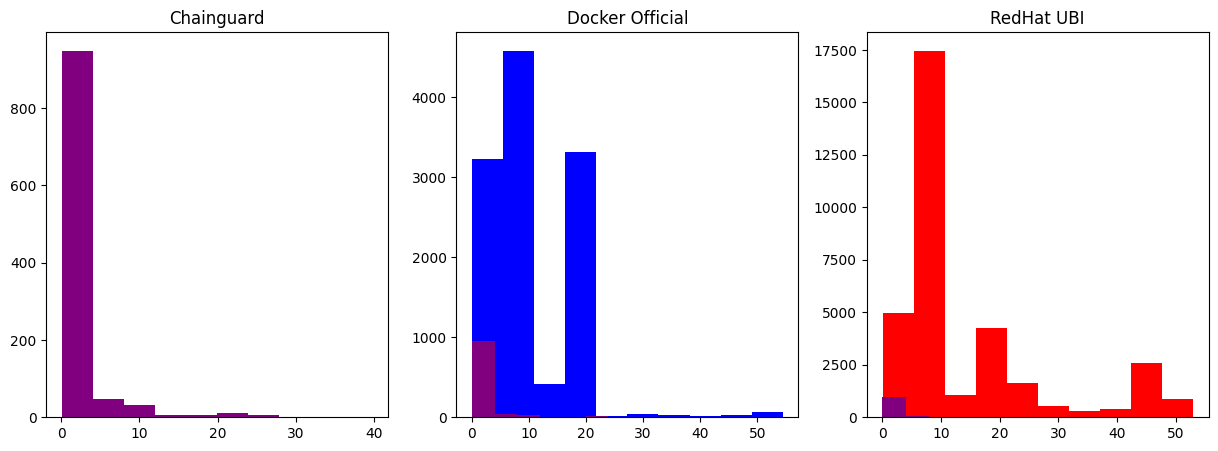

In [43]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15,5))

# Chainguard
_tab = resolved_tab.filter(label="cgr-public")
_y = _tab.remediated()["rtime"] / 24
ax[0].hist(_y, color="purple")
ax[0].set_title("Chainguard")

# Docker Official
_tab = resolved_tab.filter(label="docker-official")
_y = _tab.remediated()["rtime"] / 24
ax[1].hist(_y, color="blue")
ax[1].set_title("Docker Official")

# Chainguard vs Docker Official
_tab = resolved_tab.filter(label="cgr-public")
_y = _tab.remediated()["rtime"] / 24
ax[1].hist(_y, color="purple")

# RHEL
_tab = resolved_tab.filter(label="ubi")
_y = _tab.remediated()["rtime"] / 24
ax[2].hist(_y, color="red")
ax[2].set_title("RedHat UBI")

# Chainguard vs RHEL
_tab = resolved_tab.filter(label="cgr-public")
_y = _tab.remediated()["rtime"] / 24
ax[2].hist(_y, color="purple")

(<Figure size 640x480 with 1 Axes>,
 <Axes: xlabel='Days', ylabel='Number of CVEs'>)

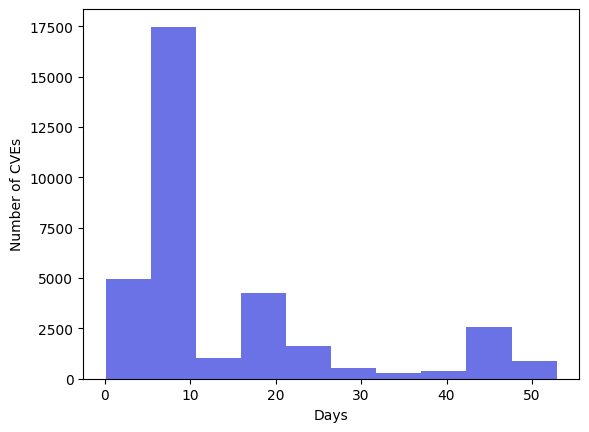

In [13]:
_tab = resolved_tab.filter(label="ubi")
rtime_hist(_tab)

(<Figure size 640x480 with 1 Axes>,
 <Axes: xlabel='Days', ylabel='Number of CVEs'>)

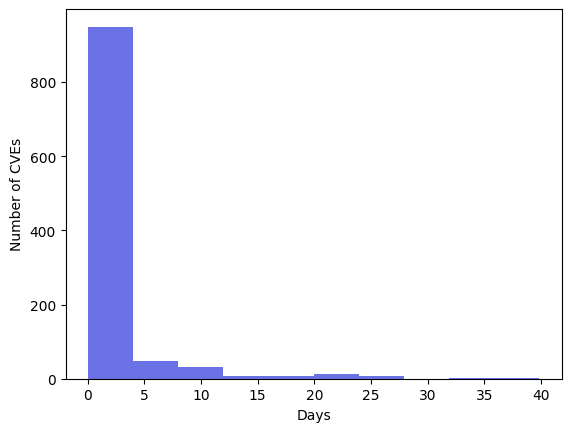

In [14]:
_tab = resolved_tab.filter(label="cgr-public")
rtime_hist(_tab)

(<Figure size 1200x500 with 1 Axes>, <Axes: >)

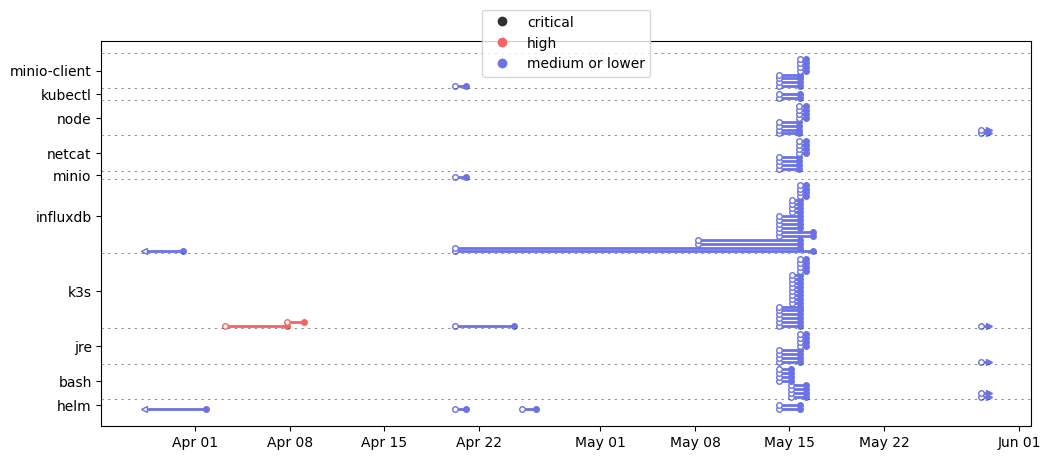

In [9]:
cgr_tab = tab.filter(label="cgr-public")
rtime_timeline(cgr_tab, figsize=(12, 5),
               include_cve_ids=False,
               max_images=10)

keycloak:
    - GHSA-f8h5-v2vg-46rr (CVE-2024-2700)
        > published 15 days ago
        > fixed 6 hours ago